# ***Data Analytics Competition (DAC) IFest***
## *Tim Laskar Pasrah*

### Anggota Tim:
1. Annisa Fitria Anwar Damanik
1. Nasywa Safira Ardanty
1. Kamal Muftie Yafi
1. Rifa Nayaka Utami

# *Import library/packages & data*

## *Import modules*

In [1]:
!pip install emoji --upgrade
!pip install unidecode
!pip install PySastrawi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

#Text cleaning
import re, string
import emoji
import unicodedata

import warnings; warnings.simplefilter('ignore')
import nltk
from unidecode import unidecode
from html import unescape

## *Import csv data*

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/kmyafi/Emotion-Analysis/main/Dataset%20Babak%20Penyisihan.csv")

In [4]:
df

,label,tweet
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,..."
2,joy,Jumat lalu nonton inih! Selain tertarik settin...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...
4,love,Happy annyversarry yg pertama kalinya .. Trsra...
...,...,...
5148,NaN,Aku termasuk orang yang tidak habis pikir deng...
5149,NaN,"Melawan sibuk Selasamu, jangan patah semangat ..."
5150,NaN,Momen di mana kamu merasa begitu mendalam terh...
5151,NaN,Tapi tentunya secara ini Bekasi ada hal-hal yg...


# *Pre-processing*

## Hitung distribusi masing-masing label

In [5]:
df['label'].value_counts()

sadness    1123
joy        1002
anger       876
fear        654
love        498
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

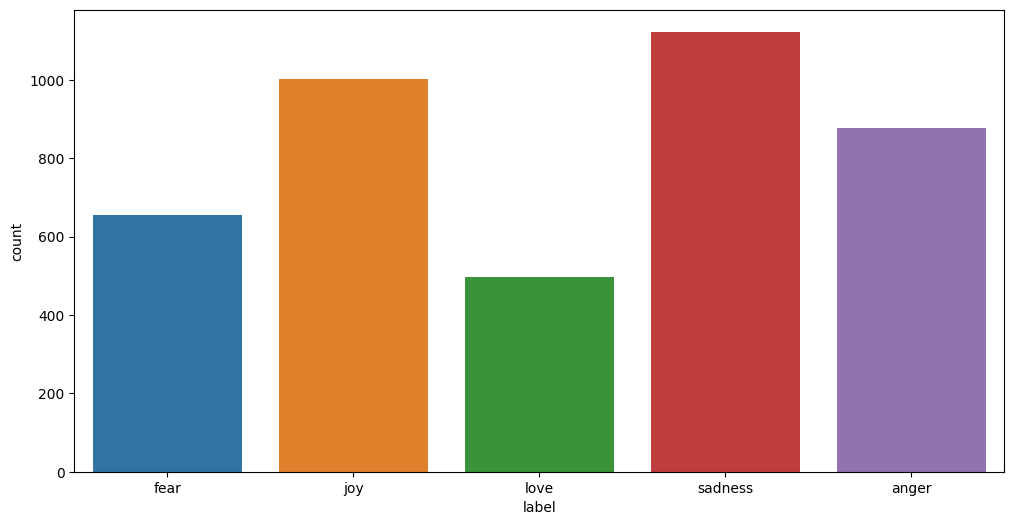

In [6]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'label', data = df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153 entries, 0 to 5152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4153 non-null   object
 1   tweet   5151 non-null   object
dtypes: object(2)
memory usage: 80.6+ KB


## *Check* NaN / isna / isnull

In [8]:
df.isna().sum()

label    1000
tweet       2
dtype: int64

#### *Drop* NaN

In [9]:
df.dropna(subset = ['tweet'], inplace=True)

In [10]:
df.isna().sum()

label    1000
tweet       0
dtype: int64

## *Texts deep cleaning*

#### Buat fungsi untuk *cleaning*

In [11]:
#remove unichar like emoji in utf-8
unichar = pd.read_csv("https://raw.githubusercontent.com/kmyafi/Emotion-Analysis/main/utf8_char.csv", sep='\t', header = None)
unichar_values = unichar[2].values
def remove_unichar_emoji(text):
    for i in unichar_values:
        text = text.replace(str(i), " ")
    return text

#Clean emojis from text
def strip_emoji(text):
    try:
        text = text.encode('latin1').decode('unicode-escape').encode('latin1').decode('utf8')
    except:
        pass
    #return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji
    return emoji.replace_emoji(text, replace=' ')

# remove semua karakter terkait html: unescape html eg. &nbsp; &amp; | link/url | tag html
import html
def remove_html(text):
    text = html.unescape(text)
    tag_pattern = re.compile(r'<.*?>')
    text = tag_pattern.sub(r'',text)
    regex_str = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    url_pattern = re.compile(regex_str)
    text = url_pattern.sub(r'', text)
    return text


# Fungsi untuk replace Accented Characters (Non-ASCII) dengan yg equivalen
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.lower()
    text = re.sub(r'(\w)(\1{2,})', r"\1", text) # will replace repeated char
    text = text.replace('\\r', ' ').replace('\\n', ' ') #remove \n and \r
    text = re.sub(r"\S*@\S*\s?", " ", text) #remove email
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r' ', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = text.translate(text.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = ' '.join(word for word in text.split() if not word.isnumeric()) #remove word only number
    text = re.sub(r'\b\w\b', "", text) #remove one letter only
    text = re.sub("(username|user|url|rt)\s|\s(user|url|rt)","",text)
    text = ' '.join(word for word in text.split() if len(word) < 21) # remove words longer than 21 characters
    text = ' '.join(word for word in text.split() if len(word) > 1) # remove words contain single letter only
    return text

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

kamus_alay1 = pd.read_csv('https://raw.githubusercontent.com/kmyafi/Emotion-Analysis/main/new_kamusalay.csv', encoding='CP1252', dtype = str, names=['alay', 'formal'])
kamus_alay1 = kamus_alay1.drop_duplicates(subset=['alay'], keep='first')
kamus_alay1 = kamus_alay1.set_index('alay')

def clean_alay(text):
    text_split = text.split(' ') #normalisasi
    for i in range(len(text_split)):
        if text_split[i] in kamus_alay1.index:
            text_split[i] = kamus_alay1.loc[text_split[i]]['formal']
    result = ' '.join(map(str, text_split))
    ######hilangkan lagi angka yg muncul
    result = ' '.join(word for word in result.split() if not word.isnumeric())
    return result

#Aplikasikan seluruh functions sesuai urutan
def clean_normalize(text):
    text = remove_unichar_emoji(text)
    text = strip_emoji(text)
    text = remove_html(text)
    text = remove_accented_chars(text)
    text = strip_all_entities(text)
    text = remove_mult_spaces(text)
    text = clean_alay(text)
    return text

In [12]:
# melakukan pembersihan data
def clean_text(text):   # fungsi membersihkan teks
    text = unescape(text) # decoding/mengubah kode simbol menjadi simbol
    text = unidecode(text)  # encoding/mengubah simbol menjadi kata

    getHashtags = re.compile(r"#(\w+)")
    pisahtags = re.compile(r'[A-Z][^A-Z]*')
    tagS = re.findall(getHashtags, text)
    for tag in tagS:
        proper_words = ' '.join(re.findall(pisahtags, tag))
        text = text.replace('#'+tag,proper_words) #mengganti hashtag jadi kata dasarnya
    #text = str(text).lower()   # menjadikan teks huruf nonkapital
    return text

In [13]:
texts_new = df['tweet'].values
texts_new

array(["Lebih menyeramkan kalo punya grup WA keluarga yg isinya sharing2 hadist & ayat Al-Qur'an DAN grup WA lingkungan paroki gereja.... Serem kalo salah reply",
       'Hepibesdey canteeeekk [USERNAME] panjang umur, jadi pribadi yang jauh lebih baik, semoga apa yang di cita-citakan terwujud dan langgeng sama [USERNAME]',
       'Jumat lalu nonton inih! Selain tertarik settingnya yg di Jogja, aku penasaran stlh baca bahaya laten acak2 rambut di review Kak [USERNAME] Dan emang bagus banget! Mata sembab gak karuan. Nonton yuk mumpung masih tayang.',
       ...,
       'Momen di mana kamu merasa begitu mendalam terhubung dengan energi positif seseorang, seperti kamu terinspirasi untuk menjadi lebih baik. 🌟🌞 #PositiveVibes',
       'Tapi tentunya secara ini Bekasi ada hal-hal yg sayangnya tidak terelakkan. 1. Bekasi itu panas. Banget. 2. Bekasi kalau weekend sore/malam itu macet. Banget. Tapi hal tsb bisa diatasin sih. Kalau panas ya pake AC. Ngindarin macet dg rencanakan jadwal keluar ru

### Lakukan pembersihan

In [14]:
text_temporary = []
for t in texts_new:
    text_temporary.append(clean_text(t))
texts_new = text_temporary
texts_new[:10]

["Lebih menyeramkan kalo punya grup WA keluarga yg isinya sharing2 hadist & ayat Al-Qur'an DAN grup WA lingkungan paroki gereja.... Serem kalo salah reply",
 'Hepibesdey canteeeekk [USERNAME] panjang umur, jadi pribadi yang jauh lebih baik, semoga apa yang di cita-citakan terwujud dan langgeng sama [USERNAME]',
 'Jumat lalu nonton inih! Selain tertarik settingnya yg di Jogja, aku penasaran stlh baca bahaya laten acak2 rambut di review Kak [USERNAME] Dan emang bagus banget! Mata sembab gak karuan. Nonton yuk mumpung masih tayang.',
 'Nyante dulu.. Sruput kopi biar tambah bijak...',
 'Happy annyversarry yg pertama kalinya .. Trsrah org mau blng apa, aku gk pdli.. Ini yg aku rasain slma 1blan.. Aku cukup bhagia sm km smuanya baik" aja, jgn ada mslh yy sayang, cemburu krna org lain wajarkan.. Dan smg kita juga makin mngrti satu sama lain.',
 'beli kaos banyak dengan ukuran yg udah downgrade, kucariin kok ngga ada ternyata masuk ke lemari Bapak, mbak ART ku kayaknya ga notice aku udah kurus

In [15]:
text_temporary = []
for t in texts_new:
    text_temporary.append(remove_unichar_emoji(t))
texts_new = text_temporary
texts_new[:10]

["Lebih menyeramkan kalo punya grup WA keluarga yg isinya sharing2 hadist & ayat Al-Qur'an DAN grup WA lingkungan paroki gereja.... Serem kalo salah reply",
 'Hepibesdey canteeeekk [USERNAME] panjang umur, jadi pribadi yang jauh lebih baik, semoga apa yang di cita-citakan terwujud dan langgeng sama [USERNAME]',
 'Jumat lalu nonton inih! Selain tertarik settingnya yg di Jogja, aku penasaran stlh baca bahaya laten acak2 rambut di review Kak [USERNAME] Dan emang bagus banget! Mata sembab gak karuan. Nonton yuk mumpung masih tayang.',
 'Nyante dulu.. Sruput kopi biar tambah bijak...',
 'Happy annyversarry yg pertama kalinya .. Trsrah org mau blng apa, aku gk pdli.. Ini yg aku rasain slma 1blan.. Aku cukup bhagia sm km smuanya baik" aja, jgn ada mslh yy sayang, cemburu krna org lain wajarkan.. Dan smg kita juga makin mngrti satu sama lain.',
 'beli kaos banyak dengan ukuran yg udah downgrade, kucariin kok ngga ada ternyata masuk ke lemari Bapak, mbak ART ku kayaknya ga notice aku udah kurus

In [16]:
text_temporary = []
for t in texts_new:
    text_temporary.append(strip_emoji(t))
texts_new = text_temporary
texts_new[:10]

["Lebih menyeramkan kalo punya grup WA keluarga yg isinya sharing2 hadist & ayat Al-Qur'an DAN grup WA lingkungan paroki gereja.... Serem kalo salah reply",
 'Hepibesdey canteeeekk [USERNAME] panjang umur, jadi pribadi yang jauh lebih baik, semoga apa yang di cita-citakan terwujud dan langgeng sama [USERNAME]',
 'Jumat lalu nonton inih! Selain tertarik settingnya yg di Jogja, aku penasaran stlh baca bahaya laten acak2 rambut di review Kak [USERNAME] Dan emang bagus banget! Mata sembab gak karuan. Nonton yuk mumpung masih tayang.',
 'Nyante dulu.. Sruput kopi biar tambah bijak...',
 'Happy annyversarry yg pertama kalinya .. Trsrah org mau blng apa, aku gk pdli.. Ini yg aku rasain slma 1blan.. Aku cukup bhagia sm km smuanya baik" aja, jgn ada mslh yy sayang, cemburu krna org lain wajarkan.. Dan smg kita juga makin mngrti satu sama lain.',
 'beli kaos banyak dengan ukuran yg udah downgrade, kucariin kok ngga ada ternyata masuk ke lemari Bapak, mbak ART ku kayaknya ga notice aku udah kurus

In [17]:
text_temporary = []
for t in texts_new:
    text_temporary.append(remove_html(t))
texts_new = text_temporary
texts_new[:10]

["Lebih menyeramkan kalo punya grup WA keluarga yg isinya sharing2 hadist & ayat Al-Qur'an DAN grup WA lingkungan paroki gereja.... Serem kalo salah reply",
 'Hepibesdey canteeeekk [USERNAME] panjang umur, jadi pribadi yang jauh lebih baik, semoga apa yang di cita-citakan terwujud dan langgeng sama [USERNAME]',
 'Jumat lalu nonton inih! Selain tertarik settingnya yg di Jogja, aku penasaran stlh baca bahaya laten acak2 rambut di review Kak [USERNAME] Dan emang bagus banget! Mata sembab gak karuan. Nonton yuk mumpung masih tayang.',
 'Nyante dulu.. Sruput kopi biar tambah bijak...',
 'Happy annyversarry yg pertama kalinya .. Trsrah org mau blng apa, aku gk pdli.. Ini yg aku rasain slma 1blan.. Aku cukup bhagia sm km smuanya baik" aja, jgn ada mslh yy sayang, cemburu krna org lain wajarkan.. Dan smg kita juga makin mngrti satu sama lain.',
 'beli kaos banyak dengan ukuran yg udah downgrade, kucariin kok ngga ada ternyata masuk ke lemari Bapak, mbak ART ku kayaknya ga notice aku udah kurus

In [18]:
text_temporary = []
for t in texts_new:
    text_temporary.append(remove_accented_chars(t))
texts_new = text_temporary
texts_new[:10]

["Lebih menyeramkan kalo punya grup WA keluarga yg isinya sharing2 hadist & ayat Al-Qur'an DAN grup WA lingkungan paroki gereja.... Serem kalo salah reply",
 'Hepibesdey canteeeekk [USERNAME] panjang umur, jadi pribadi yang jauh lebih baik, semoga apa yang di cita-citakan terwujud dan langgeng sama [USERNAME]',
 'Jumat lalu nonton inih! Selain tertarik settingnya yg di Jogja, aku penasaran stlh baca bahaya laten acak2 rambut di review Kak [USERNAME] Dan emang bagus banget! Mata sembab gak karuan. Nonton yuk mumpung masih tayang.',
 'Nyante dulu.. Sruput kopi biar tambah bijak...',
 'Happy annyversarry yg pertama kalinya .. Trsrah org mau blng apa, aku gk pdli.. Ini yg aku rasain slma 1blan.. Aku cukup bhagia sm km smuanya baik" aja, jgn ada mslh yy sayang, cemburu krna org lain wajarkan.. Dan smg kita juga makin mngrti satu sama lain.',
 'beli kaos banyak dengan ukuran yg udah downgrade, kucariin kok ngga ada ternyata masuk ke lemari Bapak, mbak ART ku kayaknya ga notice aku udah kurus

In [19]:
text_temporary = []
for t in texts_new:
    text_temporary.append(strip_all_entities(t))
texts_new = text_temporary
texts_new[:10]

['lebih menyeramkan kalo punya grup wa keluarga yg isinya sharing2 hadist ayat al qur an dan grup wa lingkungan paroki gereja serem kalo salah reply',
 'hepibesdey cantekkname panjang umur jadi pribadi yang jauh lebih baik semoga apa yang di cita citakan terwujud dan langgeng samaname',
 'jumat lalu nonton inih selain tertarik settingnya yg di jogja aku penasaran stlh baca bahaya laten acak2 rambut di review kakname dan emang bagus banget mata sembab gak karuan nonton yuk mumpung masih tayang',
 'nyante dulu sruput kopi biar tambah bijak',
 'happy annyversarry yg pertama kalinya trsrah org mau blng apa aku gk pdli ini yg aku rasain slma 1blan aku cukup bhagia sm km smuanya baik aja jgn ada mslh yy sayang cemburu krna org lain wajarkan dan smg kita juga makin mngrti satu sama lain',
 'beli kaos banyak dengan ukuran yg udah downgrade kucariin kok ngga ada ternyata masuk ke lemari bapak mbak aku kayaknya ga notice aku udah kurusan',
 'pada saat kamu menangis merengek meminta boneka atau m

In [20]:
text_temporary = []
for t in texts_new:
    text_temporary.append(remove_mult_spaces(t))
texts_new = text_temporary
texts_new[:10]

['lebih menyeramkan kalo punya grup wa keluarga yg isinya sharing2 hadist ayat al qur an dan grup wa lingkungan paroki gereja serem kalo salah reply',
 'hepibesdey cantekkname panjang umur jadi pribadi yang jauh lebih baik semoga apa yang di cita citakan terwujud dan langgeng samaname',
 'jumat lalu nonton inih selain tertarik settingnya yg di jogja aku penasaran stlh baca bahaya laten acak2 rambut di review kakname dan emang bagus banget mata sembab gak karuan nonton yuk mumpung masih tayang',
 'nyante dulu sruput kopi biar tambah bijak',
 'happy annyversarry yg pertama kalinya trsrah org mau blng apa aku gk pdli ini yg aku rasain slma 1blan aku cukup bhagia sm km smuanya baik aja jgn ada mslh yy sayang cemburu krna org lain wajarkan dan smg kita juga makin mngrti satu sama lain',
 'beli kaos banyak dengan ukuran yg udah downgrade kucariin kok ngga ada ternyata masuk ke lemari bapak mbak aku kayaknya ga notice aku udah kurusan',
 'pada saat kamu menangis merengek meminta boneka atau m

In [21]:
text_temporary = []
for t in texts_new:
    text_temporary.append(clean_alay(t))
texts_new = text_temporary
texts_new[:10]

['lebih menyeramkan kalau punya grup wa keluarga yang isinya sharing2 hadis ayat al qur an dan grup wa lingkungan paroki gereja seram kalau salah reply',
 'hepibesdey cantekkname panjang umur jadi pribadi yang jauh lebih baik semoga apa yang di cita citakan terwujud dan langgeng samaname',
 'jumat lalu menonton ini selain tertarik settingnya yang di yoyakarta aku penasaran setelah baca bahaya laten acak2 rambut di review kakname dan memang bagus banget mata sembab tidak karuan menonton yuk mumpung masih tayang',
 'nyante dulu seruput kopi biar tambah bijak',
 'happy annyversarry yang pertama kalinya trsrah orang mau bilang apa aku tidak pdli ini yang aku rasakan selama 1blan aku cukup bahagia sama km semuanya baik saja jangan ada masalah iya iya sayang cemburu karena orang lain wajarkan dan semoga kita juga makin mngrti satu sama lain',
 'beli kaos banyak dengan ukuran yang sudah downgrade kucariin kok tidak ada ternyata masuk ke lemari bapak mbak aku kayaknya tidak notice aku sudah ku

### *Check data*

In [22]:
# check for length of row after cleaning
print('data length: ', len(texts_new))

print('\nTeks ke DataFrame:')
# import texts new to dataframe
df['text_clean'] = texts_new
display(df.head(10), df.tail(10))

data length:  5151

Teks ke DataFrame:


,label,tweet,text_clean
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,lebih menyeramkan kalau punya grup wa keluarga...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",hepibesdey cantekkname panjang umur jadi priba...
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,jumat lalu menonton ini selain tertarik settin...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,nyante dulu seruput kopi biar tambah bijak
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,happy annyversarry yang pertama kalinya trsrah...
5,sadness,beli kaos banyak dengan ukuran yg udah downgra...,beli kaos banyak dengan ukuran yang sudah down...
6,love,Pada saat kamu menangis merengek meminta bonek...,pada saat kamu menangis merengek meminta bonek...
7,anger,[USERNAME] tolong aplikasinya diberesin. Saya ...,tolong aplikasinya diberesin saya tadi pesan k...
8,sadness,"Percaya kata lelaki itu, terutama ketika aku i...",percaya kata lelaki itu terutama ketika aku in...
9,sadness,ada saatnya sakit hati itu kita nikmatin denga...,ada saatnya sakit hati itu kita menikmati deng...


,label,tweet,text_clean
5143,NaN,1thn aku memang jauh dari mereka Tapi aku tahu...,1thn aku memang jauh dari mereka tapi aku tahu...
5144,NaN,Ya kalau hanya cukup dengan minta maaf untuk a...,ya kalau hanya cukup dengan meminta maaf untuk...
5145,NaN,DUL ERA JOKOWI JAUH LEBIH BAIK DARI PADA REZIM...,dul era jokowi jauh lebih baik dari pada rezim...
5146,NaN,Cinta datang tanpa di rencanakan Cinta datang ...,cinta datang tanpa di rencanakan cinta datang ...
5147,NaN,Saat pintu berderik-derik terbuka sendiri,saat pintu berderik derik terbuka sendiri
5148,NaN,Aku termasuk orang yang tidak habis pikir deng...,aku termasuk orang yang tidak habis pikir deng...
5149,NaN,"Melawan sibuk Selasamu, jangan patah semangat ...",melawan sibuk selasamu jangan patah semangat ya
5150,NaN,Momen di mana kamu merasa begitu mendalam terh...,momen di mana kamu merasa begitu mendalam terh...
5151,NaN,Tapi tentunya secara ini Bekasi ada hal-hal yg...,tapi tentunya secara ini bekasi ada hal hal ya...
5152,NaN,Happy Mensive My Love makasih udh nemenin sela...,happy mensive my love terima kasih sudah menem...


## Split Label-Unlabeled

In [23]:
# Splitting labeled
df_labeled = df[df['label'].notnull()]
df_labeled

,label,tweet,text_clean
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,lebih menyeramkan kalau punya grup wa keluarga...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",hepibesdey cantekkname panjang umur jadi priba...
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,jumat lalu menonton ini selain tertarik settin...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,nyante dulu seruput kopi biar tambah bijak
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,happy annyversarry yang pertama kalinya trsrah...
...,...,...,...
4148,anger,sini berobat sama saya ini ngantri dokter saja...,sini berobat sama saya ini mengantre dokter sa...
4149,joy,Selamat pagi generasi Tik Tok yang kadang kepa...,selamat pagi generasi tik tok yang kadang kepa...
4150,love,"Salah satu sahabat terbaik! Teman, kakak, insp...",salah satu sahabat terbaik teman kakak inspira...
4151,anger,[USERNAME] Gila kok ada ya perempuan pikiranny...,gila kok ada ya perempuan pikirannya malah nyi...


In [24]:
# Splitting NaN
df_nan = df[df['label'].isnull()]
df_nan

,label,tweet,text_clean
4153,NaN,Saya taKan raguKan besarNya kasih sayang Tuhan...,saya tak akan ragukan besarnya kasih sayang tu...
4154,NaN,Cc in ke cebong2 dungu... Maksd hati pengen ca...,cc in ke cebong cebong dungu maksud hati ingin...
4155,NaN,"Nah, yg keterlaluan adl kalo ada pjbt eselon y...",nah yang keterlaluan adalah kalau ada pjbt ese...
4156,NaN,Melody masih membatasi diri ala member ya? Yan...,melody masih membatasi diri ala member ya yang...
4157,NaN,Rasa amarah ini membuatku merasa seperti aku a...,rasa amarah ini membuatku merasa seperti aku a...
...,...,...,...
5148,NaN,Aku termasuk orang yang tidak habis pikir deng...,aku termasuk orang yang tidak habis pikir deng...
5149,NaN,"Melawan sibuk Selasamu, jangan patah semangat ...",melawan sibuk selasamu jangan patah semangat ya
5150,NaN,Momen di mana kamu merasa begitu mendalam terh...,momen di mana kamu merasa begitu mendalam terh...
5151,NaN,Tapi tentunya secara ini Bekasi ada hal-hal yg...,tapi tentunya secara ini bekasi ada hal hal ya...


### *Check duplicates after cleaning*

In [25]:
print('shape:', df_labeled.shape)

# how many duplicate texts row are there?
print('duplicate:', df_labeled['text_clean'].duplicated().sum())

# show the duplicated row
df_labeled[df_labeled['text_clean'].duplicated()]

shape: (4151, 3)
duplicate: 113


,label,tweet,text_clean
213,fear,[USERNAME] [USERNAME] Tidak disemua tempat kit...,tidak di semua tempat kita boleh melaksanakan ...
325,sadness,Momen di mana kamu merasa seperti kamu berjala...,momen di mana kamu merasa seperti kamu berjala...
350,anger,Rasa amarah ini membuatku merasa seperti aku a...,rasa amarah ini membuatku merasa seperti aku a...
504,sadness,Rasa kesepian dan kehilangan ini membuatku mer...,rasa kesepian dan kehilangan ini membuatku mer...
506,sadness,Saat kamu merasakan rasa hampa dan kesepian ya...,saat kamu merasakan rasa hampa dan kesepian ya...
...,...,...,...
3953,anger,Aku merasa seperti aku bisa merobek segala ses...,aku merasa seperti aku bisa merobek segala ses...
4017,love,Cinta adalah ketika kamu merasa seperti kamu b...,cinta adalah ketika kamu merasa seperti kamu b...
4044,anger,Aku merasa seperti aku harus berjuang untuk me...,aku merasa seperti aku harus berjuang untuk me...
4077,anger,Rasa amarah ini membuatku merasa seperti aku a...,rasa amarah ini membuatku merasa seperti aku a...


In [26]:
# drop duplicate data
df_labeled.drop_duplicates(['text_clean'], keep='first', inplace=True)
df_labeled = df_labeled.reset_index(drop=True)
print('new shape:', df_labeled.shape)

new shape: (4038, 3)


### *Check for* NaN *or empty cell*

In [27]:
df_labeled.isna().sum()

label         0
tweet         0
text_clean    0
dtype: int64

In [28]:
#contain only space row?
df_labeled[df_labeled['text_clean'] == '']

,label,tweet,text_clean
2879,fear,#ERROR!,


### Cek panjang kata setelah *cleaning*

In [29]:
df_labeled['length'] = df_labeled['text_clean'].str.split().map(lambda x: len(x))
df_labeled

,label,tweet,text_clean,length
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,lebih menyeramkan kalau punya grup wa keluarga...,25
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",hepibesdey cantekkname panjang umur jadi priba...,20
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,jumat lalu menonton ini selain tertarik settin...,34
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,nyante dulu seruput kopi biar tambah bijak,7
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,happy annyversarry yang pertama kalinya trsrah...,47
...,...,...,...,...
4033,anger,sini berobat sama saya ini ngantri dokter saja...,sini berobat sama saya ini mengantre dokter sa...,15
4034,joy,Selamat pagi generasi Tik Tok yang kadang kepa...,selamat pagi generasi tik tok yang kadang kepa...,24
4035,love,"Salah satu sahabat terbaik! Teman, kakak, insp...",salah satu sahabat terbaik teman kakak inspira...,23
4036,anger,[USERNAME] Gila kok ada ya perempuan pikiranny...,gila kok ada ya perempuan pikirannya malah nyi...,22


In [30]:
#hapus data yang hanya berisi satu kata
df_labeled = df_labeled[df_labeled['length'] > 1]

# reset index
df_labeled = df_labeled.reset_index(drop=True)
df_labeled

,label,tweet,text_clean,length
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,lebih menyeramkan kalau punya grup wa keluarga...,25
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",hepibesdey cantekkname panjang umur jadi priba...,20
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,jumat lalu menonton ini selain tertarik settin...,34
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,nyante dulu seruput kopi biar tambah bijak,7
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,happy annyversarry yang pertama kalinya trsrah...,47
...,...,...,...,...
4032,anger,sini berobat sama saya ini ngantri dokter saja...,sini berobat sama saya ini mengantre dokter sa...,15
4033,joy,Selamat pagi generasi Tik Tok yang kadang kepa...,selamat pagi generasi tik tok yang kadang kepa...,24
4034,love,"Salah satu sahabat terbaik! Teman, kakak, insp...",salah satu sahabat terbaik teman kakak inspira...,23
4035,anger,[USERNAME] Gila kok ada ya perempuan pikiranny...,gila kok ada ya perempuan pikirannya malah nyi...,22


In [31]:
df_labeled['label'].value_counts()

sadness    1072
joy         994
anger       840
fear        645
love        486
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

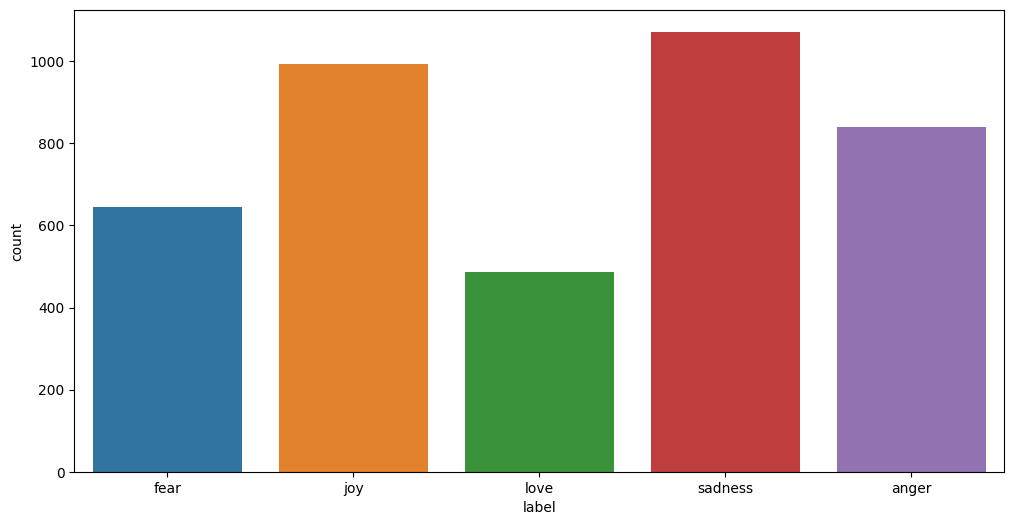

In [32]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'label', data = df_labeled)

In [33]:
#simpan ke file untuk backup
df_labeled.to_csv('/content/data_clean.csv', encoding = 'utf-8', index = False)
df_nan.to_csv('/content/data_validation.csv', encoding = 'utf-8', index = False)

# *Split Train-Test*

In [34]:
from sklearn.model_selection import train_test_split
seed_val = 42

In [35]:
df1 = df_labeled[['text_clean','label']]

data_train, data_test = train_test_split(df1, test_size = 0.2,
                                         stratify = df1['label'], random_state = seed_val)

In [36]:
data_train.to_csv('/content/data_train.csv', encoding='utf-8', index=False)
data_test.to_csv('/content/data_test.csv',   encoding='utf-8', index=False)

# *Choosing model*

In [37]:
#Libraries for general purpose
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns

#Data preprocessing
from sklearn.model_selection import train_test_split

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


# Classifier: NB, LR, DT, RF, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Metric
from sklearn.metrics import classification_report, accuracy_score, f1_score

#Counter
#from collections import Counter

# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm

#Seed for reproducibility
import random

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

## *Model Classifier Function*

In [38]:
score_f1_acc = pd.DataFrame(np.zeros(shape=(7,3)), columns=['model', 'F1 Score', 'Accuracy'])
pred_df = pd.DataFrame()

def model_clf(clf, loc, model_name):
    #clf.fit(X_train, y_train.tolist())
    clf.fit(X_train, y_train)
    acc_train = clf.score(X_train, y_train)

    predictions = clf.predict(X_test)
    acc_test = accuracy_score(y_test, predictions)
    f_one = f1_score(y_test, predictions, average = 'micro')

    print(pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']))
    print()
    print(classification_report(y_test, predictions))
    print('Accuracy X_train: {:.2f}'.format(round(acc_train*100, 2)))
    print('Accuracy X_test: {:.2f}'.format(round(acc_test*100, 2)))
    print('F1 Score: {:.2f}'.format(round(f_one*100, 2)))
    #print(round(f_one*100, 2), round(acc_test*100, 2))
    score_f1_acc.loc[loc] = [model_name, round(f_one*100, 2), round(acc_test*100, 2)]

    predictions_val = clf.predict(X_val)
    pred_val = pd.DataFrame(predictions_val, columns = ['label_{}'.format(model_name)])
    pred_df['label_{}'.format(model_name)] = pred_val
    print(predictions_val)

## 1. *Bag of Words (BoW) as Feature*

In [39]:
df_labeled['label'] = df_labeled['label'].replace(['sadness', 'joy', 'love', 'fear', 'anger'], ['0', '1', '2', '3', '4'])

In [40]:
X = df_labeled["text_clean"].values
y = df_labeled["label"].values

X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)
X_val_pre = df_nan["text_clean"].values

count_vectorizer = CountVectorizer()

X_train = count_vectorizer.fit_transform(X_train_pre)
X_test  = count_vectorizer.transform(X_test_pre)
X_val  = count_vectorizer.transform(X_val_pre)

### Naive Bayes

In [41]:
clf = MultinomialNB()
#clf = GaussianNB()
model_clf(clf, 0, 'NB-BoW')

Predicted    0    1   2   3    4
Actual                          
0          158   23   2   8   23
1           61  115   4   5   12
2           29    8  57   2    3
3           41    5   0  76    9
4           41    9   0   3  114

              precision    recall  f1-score   support

           0       0.48      0.74      0.58       214
           1       0.72      0.58      0.64       197
           2       0.90      0.58      0.70        99
           3       0.81      0.58      0.68       131
           4       0.71      0.68      0.70       167

    accuracy                           0.64       808
   macro avg       0.72      0.63      0.66       808
weighted avg       0.69      0.64      0.65       808

Accuracy X_train: 94.05
Accuracy X_test: 64.36
F1 Score: 64.36
['0' '4' '4' '1' '4' '0' '1' '3' '0' '1' '1' '4' '4' '3' '0' '1' '4' '1'
 '1' '3' '4' '4' '1' '2' '1' '2' '1' '2' '0' '4' '2' '3' '0' '1' '1' '4'
 '0' '3' '1' '4' '1' '0' '1' '0' '4' '0' '0' '2' '1' '4' '0' '1' '2' '

### SVC

In [42]:
clf = SVC()
#clf = SVC(kernel ='linear', C = 1)
model_clf(clf, 1, 'SVM-BoW')

Predicted    0    1   2   3    4
Actual                          
0          142   41   6   1   24
1           47  127   7   3   13
2           15   15  64   1    4
3           42   10   1  70    8
4           50   16   0   1  100

              precision    recall  f1-score   support

           0       0.48      0.66      0.56       214
           1       0.61      0.64      0.63       197
           2       0.82      0.65      0.72        99
           3       0.92      0.53      0.68       131
           4       0.67      0.60      0.63       167

    accuracy                           0.62       808
   macro avg       0.70      0.62      0.64       808
weighted avg       0.66      0.62      0.63       808

Accuracy X_train: 94.89
Accuracy X_test: 62.25
F1 Score: 62.25
['2' '4' '4' '4' '4' '1' '1' '3' '0' '1' '1' '4' '4' '0' '2' '4' '4' '1'
 '1' '1' '4' '4' '0' '2' '1' '0' '1' '2' '4' '4' '2' '3' '4' '1' '4' '4'
 '0' '3' '1' '4' '2' '0' '1' '2' '4' '1' '2' '0' '1' '0' '0' '1' '2' '

### Logistic Regression

In [43]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
model_clf(clf, 2, 'LR-BoW')

Predicted    0    1   2   3    4
Actual                          
0          137   33   9   9   26
1           36  125  10   7   19
2           16   13  66   2    2
3           20   10   2  90    9
4           40   16   1   7  103

              precision    recall  f1-score   support

           0       0.55      0.64      0.59       214
           1       0.63      0.63      0.63       197
           2       0.75      0.67      0.71        99
           3       0.78      0.69      0.73       131
           4       0.65      0.62      0.63       167

    accuracy                           0.64       808
   macro avg       0.67      0.65      0.66       808
weighted avg       0.65      0.64      0.65       808

Accuracy X_train: 99.97
Accuracy X_test: 64.48
F1 Score: 64.48
['2' '4' '0' '0' '4' '4' '1' '3' '4' '2' '1' '4' '4' '3' '2' '0' '4' '1'
 '1' '4' '4' '4' '2' '2' '1' '0' '1' '2' '0' '4' '2' '3' '0' '1' '4' '4'
 '0' '3' '1' '4' '1' '0' '1' '0' '4' '0' '2' '1' '0' '4' '0' '1' '2' '

### Decision Tree

In [44]:
clf = DecisionTreeClassifier(criterion='entropy')
model_clf(clf, 3, 'DT-BoW')

Predicted   0   1   2   3   4
Actual                       
0          83  43  16  16  56
1          38  91  17  12  39
2          18  10  65   5   1
3          15  10   4  92  10
4          36  31   4   9  87

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       214
           1       0.49      0.46      0.48       197
           2       0.61      0.66      0.63        99
           3       0.69      0.70      0.69       131
           4       0.45      0.52      0.48       167

    accuracy                           0.52       808
   macro avg       0.54      0.55      0.54       808
weighted avg       0.52      0.52      0.52       808

Accuracy X_train: 100.00
Accuracy X_test: 51.73
F1 Score: 51.73
['0' '0' '0' '0' '4' '0' '1' '3' '4' '1' '0' '4' '4' '0' '2' '2' '4' '1'
 '0' '4' '4' '3' '2' '2' '1' '1' '1' '2' '2' '3' '2' '4' '4' '0' '2' '0'
 '0' '3' '1' '0' '2' '0' '0' '2' '4' '1' '1' '0' '1' '2' '2' '2' '2' '0'
 '4' '0' '0' '4' 

## 2. *TFIDF Vectorizer as Feature*

In [45]:
X = df_labeled["text_clean"].values
y = df_labeled["label"].values

X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(X_train_pre)
X_test  = tfidf_vectorizer.transform(X_test_pre)

### Naive Bayes

In [46]:
clf = MultinomialNB()
#clf = GaussianNB()
model_clf(clf, 4, 'NB-TfIdf')

Predicted    0    1  2   3   4
Actual                        
0          186   18  0   0  10
1           94  101  0   0   2
2           73   19  6   0   1
3           93    3  0  31   4
4           83    8  0   0  76

              precision    recall  f1-score   support

           0       0.35      0.87      0.50       214
           1       0.68      0.51      0.58       197
           2       1.00      0.06      0.11        99
           3       1.00      0.24      0.38       131
           4       0.82      0.46      0.58       167

    accuracy                           0.50       808
   macro avg       0.77      0.43      0.43       808
weighted avg       0.71      0.50      0.47       808

Accuracy X_train: 76.93
Accuracy X_test: 49.50
F1 Score: 49.50
['0' '4' '0' '0' '0' '0' '1' '0' '0' '1' '1' '4' '4' '0' '0' '0' '4' '1'
 '1' '4' '4' '4' '0' '2' '1' '0' '1' '2' '0' '0' '0' '0' '0' '1' '0' '4'
 '0' '3' '1' '4' '0' '0' '0' '0' '4' '0' '0' '0' '1' '0' '0' '1' '2' '0'
 '0' '0' '0

### SVC

In [47]:
clf = SVC()
model_clf(clf, 5, 'SVM-TfIdf')

Predicted    0    1   2   3    4
Actual                          
0          154   32   6   0   22
1           45  134   4   2   12
2           20   12  65   1    1
3           38   10   0  74    9
4           50   16   0   1  100

              precision    recall  f1-score   support

           0       0.50      0.72      0.59       214
           1       0.66      0.68      0.67       197
           2       0.87      0.66      0.75        99
           3       0.95      0.56      0.71       131
           4       0.69      0.60      0.64       167

    accuracy                           0.65       808
   macro avg       0.73      0.64      0.67       808
weighted avg       0.70      0.65      0.66       808

Accuracy X_train: 99.23
Accuracy X_test: 65.22
F1 Score: 65.22
['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '

### Logistic Regression

In [48]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
model_clf(clf, 6, 'LR-TfIdf')

Predicted    0    1   2   3    4
Actual                          
0          144   34   6   5   25
1           36  139   4   3   15
2           17   11  67   1    3
3           29   10   0  83    9
4           41   16   0   2  108

              precision    recall  f1-score   support

           0       0.54      0.67      0.60       214
           1       0.66      0.71      0.68       197
           2       0.87      0.68      0.76        99
           3       0.88      0.63      0.74       131
           4       0.68      0.65      0.66       167

    accuracy                           0.67       808
   macro avg       0.73      0.67      0.69       808
weighted avg       0.69      0.67      0.67       808

Accuracy X_train: 91.79
Accuracy X_test: 66.96
F1 Score: 66.96
['2' '4' '4' '4' '4' '1' '1' '3' '0' '2' '1' '4' '4' '3' '2' '4' '4' '2'
 '1' '4' '4' '4' '2' '2' '2' '0' '1' '2' '2' '4' '2' '3' '0' '1' '2' '4'
 '0' '3' '1' '4' '2' '0' '0' '2' '4' '0' '2' '2' '0' '2' '2' '2' '2' '

### Decision Tree

In [49]:
clf = DecisionTreeClassifier(criterion='entropy')
model_clf(clf, 7, 'DT-TfIdf')

Predicted   0   1   2   3   4
Actual                       
0          98  44  21  16  35
1          51  77  17  13  39
2          14  11  64   5   5
3          20   9   3  92   7
4          63  22   4  10  68

              precision    recall  f1-score   support

           0       0.40      0.46      0.43       214
           1       0.47      0.39      0.43       197
           2       0.59      0.65      0.62        99
           3       0.68      0.70      0.69       131
           4       0.44      0.41      0.42       167

    accuracy                           0.49       808
   macro avg       0.52      0.52      0.52       808
weighted avg       0.49      0.49      0.49       808

Accuracy X_train: 100.00
Accuracy X_test: 49.38
F1 Score: 49.38
['0' '0' '4' '4' '4' '1' '2' '0' '4' '3' '1' '3' '4' '4' '2' '2' '4' '1'
 '1' '4' '4' '4' '2' '0' '1' '1' '1' '2' '0' '0' '2' '4' '4' '4' '4' '0'
 '0' '3' '1' '0' '2' '1' '0' '0' '4' '1' '2' '4' '0' '2' '0' '2' '0' '0'
 '4' '1' '4' '0' 

In [50]:
#print all scores
score_f1_acc

,model,F1 Score,Accuracy
0,NB-BoW,64.36,64.36
1,SVM-BoW,62.25,62.25
2,LR-BoW,64.48,64.48
3,DT-BoW,51.73,51.73
4,NB-TfIdf,49.50,49.50
5,SVM-TfIdf,65.22,65.22
6,LR-TfIdf,66.96,66.96
7,DT-TfIdf,49.38,49.38


# *Predict*

In [51]:
df_val = df_nan.copy()
df_val.reset_index(inplace = True)

In [52]:
df_val['label'] = pred_df['label_LR-TfIdf']

In [53]:
df_val['label'] = df_val['label'].replace(['0', '1', '2', '3', '4'], ['sadness', 'joy', 'love', 'fear', 'anger'])

In [54]:
display(df_val)

,index,label,tweet,text_clean
0,4153,love,Saya taKan raguKan besarNya kasih sayang Tuhan...,saya tak akan ragukan besarnya kasih sayang tu...
1,4154,anger,Cc in ke cebong2 dungu... Maksd hati pengen ca...,cc in ke cebong cebong dungu maksud hati ingin...
2,4155,anger,"Nah, yg keterlaluan adl kalo ada pjbt eselon y...",nah yang keterlaluan adalah kalau ada pjbt ese...
3,4156,anger,Melody masih membatasi diri ala member ya? Yan...,melody masih membatasi diri ala member ya yang...
4,4157,anger,Rasa amarah ini membuatku merasa seperti aku a...,rasa amarah ini membuatku merasa seperti aku a...
...,...,...,...,...
995,5148,anger,Aku termasuk orang yang tidak habis pikir deng...,aku termasuk orang yang tidak habis pikir deng...
996,5149,fear,"Melawan sibuk Selasamu, jangan patah semangat ...",melawan sibuk selasamu jangan patah semangat ya
997,5150,love,Momen di mana kamu merasa begitu mendalam terh...,momen di mana kamu merasa begitu mendalam terh...
998,5151,fear,Tapi tentunya secara ini Bekasi ada hal-hal yg...,tapi tentunya secara ini bekasi ada hal hal ya...


In [55]:
df_val.to_csv('/content/data_result.csv', encoding='utf-8', index=False)